# <span style="color:#F72585"><center>Modelo de clasificación para detección de fraude en tarjetas de crédito</center></span>

<figure>
<center>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Alejandria/main/Redes_Neuronales/Imagenes/Credit-cards.jpg" width="600" height="400" align="center" /> 
</center>   
</figure>
<center>

Fuente: <a href="https://commons.wikimedia.org/wiki/File:Credit-cards.jpg">Lotus Head from Johannesburg, Gauteng, South Africa</a>, <a href="http://creativecommons.org/licenses/by-sa/3.0/">CC BY-SA 3.0</a>, via Wikimedia Commons

</center>

## <span style="color:#4361EE">Introducción</span> 

En esta lección hacemos ejemplo de clasificación para detectar fraude en el uso de tarjeta de crédito. El ejemplo es adaptado de  [fchollet](https://github.com/keras-team/keras-io/blob/master/examples/structured_data/imbalanced_classification.py). Los datos están disponible en [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/).

El propósito del ejemplo es ilustrar el caso de datos categóricos altamente desbalanceados. Un  problema muy común en la práctica. Usaremos varias métricas para evaluar el modelo.

La técnica se puede extender a la detección de datos anómalos en grades conjuntos de datos.

## <span style="color:#4361EE">Importa módulos</span> 

In [39]:
from __future__ import absolute_import, division, print_function, unicode_literals
#
#import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#

from tensorflow.keras.models import Model
#
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
#
from tensorflow.keras.utils import plot_model
#
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#
from tensorflow.keras. metrics import FalseNegatives, FalsePositives, TrueNegatives
from tensorflow.keras. metrics import TruePositives, Precision, Recall
#
from tensorflow.keras.optimizers import Adam
#
from tensorflow.keras import callbacks
#
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
print(tf.__version__)

2.9.1


## <span style="color:#4361EE">Los datos</span> 

Excepto por la transacción y el monto, no sabemos cuáles son las otras columnas (por razones de privacidad). Lo único que sabemos es que esas columnas que se desconocen ya se han escalado. Son 284.807 registros y 31 variables.

- *El monto de la transacción* es relativamente pequeño. La media de todas las transacciones realizadas es de aproximadamente USD 88.

- *No hay valores faltantes*

- *La mayoría de las transacciones fueron no fraudulentas* (99,82%) del tiempo, mientras que las transacciones fraudulentas ocurren (018%) del tiempo en el marco de datos.

- *Transformación PCA*: La descripción de los datos dice que todas las características pasaron por una transformación PCA (técnica de reducción de dimensionalidad) (excepto por tiempo y cantidad).

- *Escalado*: tenga en cuenta que para implementar una transformación de PCA es necesario escalar previamente las variables (features). (En este caso, todas las variables del grupo  V se han escalado o al menos eso es lo que suponemos que hicieron las personas que desarrollan el conjunto de datos).

## <span style="color:#4361EE">Lee los datos</span> 

In [40]:
fname = 'https://media.githubusercontent.com/media/AprendizajeProfundo/Alejandria/main/Redes_Neuronales/Datos/creditcard.csv'
training = pd.read_csv(fname)
training

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## <span style="color:#4361EE">Preprocesamiento</span> 

### <span style="color:#4CC9F0">Construye tensores para entrada y salida</span>


In [41]:
# Separa features y targest
targets = training.pop('Class')
targets = np.array(targets, dtype = 'uint8')
targets.reshape((targets.shape[0],1))
#
features = np.array(training,dtype = 'float32' )
#
print("tamaño de los targets: ",targets.shape)
print("tamaño de los features: ",features.shape)

tamaño de los targets:  (284807,)
tamaño de los features:  (284807, 30)


### <span style="color:#4CC9F0">Prepara datos de entrenamiento y validación</span>

In [42]:
#
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

Number of training samples: 227846
Number of validation samples: 56961


### <span style="color:#4CC9F0">Normaliza los datos</span>


In [43]:
# crea el objeto StandardScaler
scaler = StandardScaler()

# Ajusta los parámetros del scaler
scaler.fit(train_features)

# escala training y test
train_features = scaler.transform(train_features)
val_features = scaler.transform(val_features )


## <span style="color:#4361EE">Analiza el desbalance en los targets</span>


In [44]:
# Cuenta las frecuencias de los datos
counts = np.bincount(train_targets)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)

# Crea los pesos para el entrenamiento. Más peso a los menos frecuentes (1)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 417 (0.18% of total)


In [45]:
print(weight_for_1)
print(weight_for_0)

0.002398081534772182
4.396976638863118e-06


## <span style="color:#4361EE">Crea el modelo</span> 

In [46]:
inputs = Input(shape=(train_features.shape[1],),name='capa_entrada')

# vamos construyendo capa por capa
x = Activation('relu')(inputs)
x = Dense(256, activation='relu',name='primera_capa_oculta')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu',name='segunda_capa_oculta')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid', name='capa_salida')(x)

# Creamos ahora el modelo
model = Model(inputs=inputs, outputs=outputs)


### <span style="color:#4CC9F0">Summary</span>

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 capa_entrada (InputLayer)   [(None, 30)]              0         
                                                                 
 activation_3 (Activation)   (None, 30)                0         
                                                                 
 primera_capa_oculta (Dense)  (None, 256)              7936      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 segunda_capa_oculta (Dense)  (None, 256)              65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 capa_salida (Dense)         (None, 1)                 257 

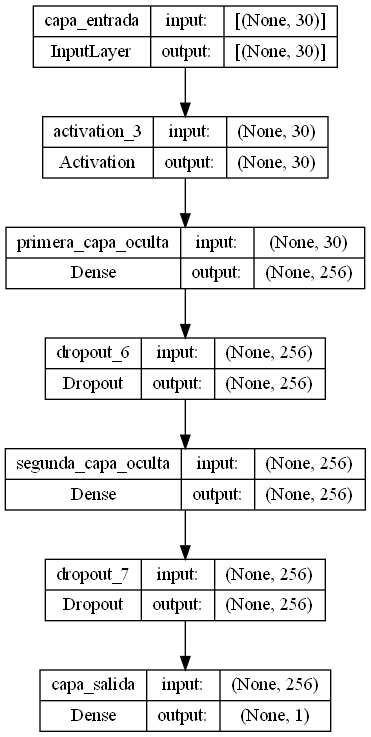

In [47]:
model.summary()
plot_model(model, show_shapes=True) # de manera local correr plot_model(model, to_file='../Imagenes/fraude_model.png', show_shapes=True) para guargar el modelo

## <span style="color:#4361EE">Define métricas y compila</span> 

- **accuracy_score**: En la clasificación con múltiples etiquetas, esta función calcula la exactitud del subconjunto: el conjunto de etiquetas predichas para una muestra que coincide exactamente con el conjunto de etiquetas correspondiente en y_true.
- **precision_score**: es la razón $\frac{tp }{tp + fp}$ en donde $tp$ es el número de positivos verdadero y $fp$ el número de falsos positivos. El mejor valor es 1 y el peor valor es 0.
- **recall_score**:  es la relación $\frac{tp }{tp + fn}$ donde $tp$ es el número de verdaderos positivos y $fn$ el número de falsos negativos. El recuerdo es intuitivamente la capacidad del clasificador para encontrar todas las muestras positivas. El mejor valor es 1 y el peor valor es 0.

In [48]:
# métricas
metrics = [
    FalseNegatives(name="fn"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    TruePositives(name="tp"),
    Precision(name="precision"),
    Recall(name="recall"),
]

model.compile(optimizer=Adam(1e-2), loss="binary_crossentropy", metrics=metrics)

## <span style="color:#4361EE">Entrena</span>  

Tiene en cuenta los pesos de las transacciones

In [49]:
#callbacks = [callbacks.ModelCheckpoint("../Datos/fraude/fraud_model_at_epoch_{epoch}.h5")] #Correr desde local
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    #callbacks=callbacks.ModelCheckpoint(), #Correr desde local
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Epoch 1/30
112/112 - 7s - loss: 2.5541e-06 - fn: 51.0000 - fp: 29977.0000 - tn: 197452.0000 - tp: 366.0000 - precision: 0.0121 - recall: 0.8777 - val_loss: 0.0955 - val_fn: 11.0000 - val_fp: 946.0000 - val_tn: 55940.0000 - val_tp: 64.0000 - val_precision: 0.0634 - val_recall: 0.8533 - 7s/epoch - 60ms/step
Epoch 2/30
112/112 - 3s - loss: 1.6553e-06 - fn: 41.0000 - fp: 8089.0000 - tn: 219340.0000 - tp: 376.0000 - precision: 0.0444 - recall: 0.9017 - val_loss: 0.1670 - val_fn: 8.0000 - val_fp: 2619.0000 - val_tn: 54267.0000 - val_tp: 67.0000 - val_precision: 0.0249 - val_recall: 0.8933 - 3s/epoch - 26ms/step
Epoch 3/30
112/112 - 3s - loss: 1.5577e-06 - fn: 36.0000 - fp: 8208.0000 - tn: 219221.0000 - tp: 381.0000 - precision: 0.0444 - recall: 0.9137 - val_loss: 0.1892 - val_fn: 7.0000 - val_fp: 2225.0000 - val_tn: 54661.0000 - val_tp: 68.0000 - val_precision: 0.0297 - val_recall: 0.9067 - 3s/epoch - 23ms/step
Epoch 4/30
112/112 - 3s - loss: 1.4653e-06 - fn: 36.0000 - fp: 7981.0000 - tn: 21

## <span style="color:#4361EE">Predicciones</span>  

In [50]:
# Predicting the Test set results
y_pred_val = model.predict(val_features)
y_pred_val[y_pred_val > 0.5] = 1
y_pred_val[y_pred_val <=0.5] = 0
y_pred_val.reshape((y_pred_val.shape[0]))
# predict the training set
y_pred_train = model.predict(train_features)
y_pred_train[y_pred_train > 0.5] = 1
y_pred_train[y_pred_train <=0.5] = 0
y_pred_train.reshape((y_pred_train.shape[0]))


7121/7121 [==============================] - 17s 2ms/step


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

## <span style="color:#4361EE">Resultados</span>  

Calcula métricas

</span>  

In [51]:
#
# elimina dimensiones sobrantes
val_targets = np.squeeze(val_targets)
y_pred_val = np.squeeze(y_pred_val)
train_targets = np.squeeze(train_targets)
y_pred_train = np.squeeze(y_pred_train)
#
# falsos negativos validación
fn_val = FalseNegatives()
fn_val.update_state(val_targets, y_pred_val)
fn_val = fn_val.result().numpy()
#
# falsos negativos entrenamiento
fn_train = FalseNegatives()
fn_train.update_state(train_targets, y_pred_train)
fn_train = fn_train.result().numpy()
# 
# falsos positivos validación
fp_val = FalsePositives()
fp_val.update_state(val_targets, y_pred_val)
fp_val = fp_val.result().numpy()
#
# falsos positivos entrenamiento
fp_train = FalsePositives()
fp_train.update_state(train_targets, y_pred_train)
fp_train = fp_train.result().numpy()
# 
# Precision validación
pre_val = Precision()
pre_val.update_state(val_targets, y_pred_val)
pre_val = pre_val.result().numpy()
#
# falsos negativos entrenamiento
pre_train = Precision()
pre_train.update_state(train_targets, y_pred_train)
pre_train = pre_train.result().numpy()
# 
# recall validación
re_val = Recall()
re_val.update_state(val_targets, y_pred_val)
re_val = re_val.result().numpy()
#
# recall entrenamiento
re_train = Recall()
re_train.update_state(train_targets, y_pred_train)
re_train = re_train.result().numpy()
# 

# diccionario
metricas = {'Falsos_positivos_train':fp_train, 'Falsos_positivos_val':fp_val,
           '%Falsos_positivos': np.round((fp_train+fp_val)/ len(training)*100,4),
           'Falsos_negativos_train':fn_train, 'Falsos_negativos_val':fn_val,
           '%Falsos_negativos': np.round((fn_train+fn_val)/ len(training)*100,4),
           'Precision_train': pre_train, 'Precision_val': pre_val,
           'Recall_train': re_train, 'Recall_val':re_val }

In [52]:
metricas

{'Falsos_positivos_train': 3746.0,
 'Falsos_positivos_val': 569.0,
 '%Falsos_positivos': 1.5151,
 'Falsos_negativos_train': 2.0,
 'Falsos_negativos_val': 11.0,
 '%Falsos_negativos': 0.0046,
 'Precision_train': 0.09973564,
 'Precision_val': 0.10110585,
 'Recall_train': 0.99520385,
 'Recall_val': 0.85333335}

## <span style="color:#4361EE">Evaluación del modelo</span>  

In [53]:

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Entrenamiento y validación '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

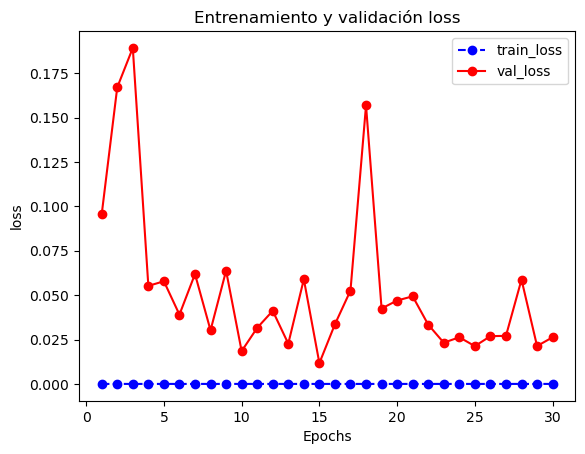

In [54]:
plot_metric(history, 'loss')

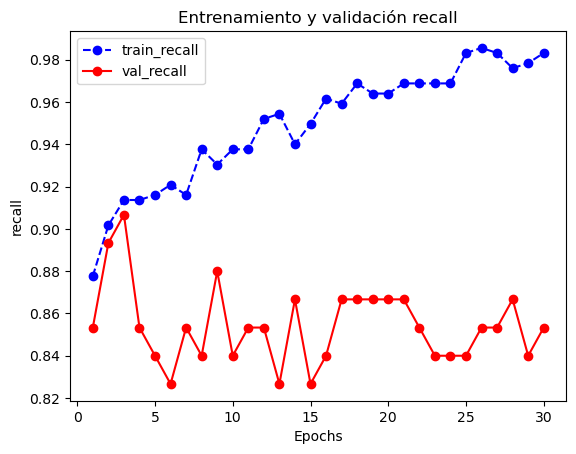

In [55]:
plot_metric(history, 'recall')

## <span style="color:#4361EE">Conclusiones</span>  

Al final del entrenamiento, de 56,961 transacciones de validación, se obtuvo:

- Identificar correctamente a 66 de ellos como fraudulentos
- Faltan 9 transacciones fraudulentas
- A costa de marcar incorrectamente 441 transacciones legítimas

En el mundo real, se le daría un peso aún mayor a la clase 1,
para reflejar que los falsos negativos son más costosos que los falsos positivos.

**La próxima vez que su tarjeta de crédito sea rechazada en una compra en línea, esta es la razón.**